# Part 1: Stochastic Gradient Descent
Understanding Stochastic Gradient Descent.
Implementing SGD without using a built-in optimizer, to understand how parameters are optimized at the low level.

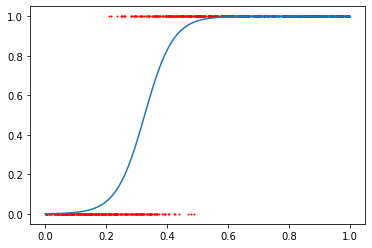

In the image above, the x and y axis correspond to the variables defined previously, with the red "dots" the true data as generated by the process defined below, and the blue line is the optimal logistic decision function learned from the data.

The optimal parameters can be found numerically using gradient descent. In this case, we will be using SGD (batched gradient descent) to optimize the two parameters in the logistic function, $\beta_1, \beta_2$.

If ${p(x)={\frac {1}{1+e^{-(\beta _{1}+\beta _{2}x)}}}}$, then we want to find $\beta_1, \beta_2$ such that the [negative log likelihood](https://en.wikipedia.org/wiki/Likelihood_function) is minimized. In this case, ${\ell =\sum _{k=1}^{K}\left(\,y_{k}\ln(p_{k})+(1-y_{k})\ln(1-p_{k})\right)}$, and the SGD formula is simply:
$\beta_i = \beta_{i-1} - \alpha * \nabla \ell$.

The data generation process as well as the pseudo-code is provided for you below, your task is to fill in the appropriate pytorch code. *Do not use the built-in optimizer*, implement SGD using tensor operations alone.


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

%matplotlib inline
torch.manual_seed(42)

In [2]:
def generate_data():
  data = torch.rand(1000, 2)
  label = ((data[:,0]+0.3*data[:,1]) > 0.5).to(torch.int)
  return data[:,0], label

Epoch [01/15], Loss: 416.76
Epoch [02/15], Loss: 263.05
Epoch [03/15], Loss: 224.38
Epoch [04/15], Loss: 206.20
Epoch [05/15], Loss: 195.55
Epoch [06/15], Loss: 188.54
Epoch [07/15], Loss: 183.60
Epoch [08/15], Loss: 179.94
Epoch [09/15], Loss: 177.14
Epoch [10/15], Loss: 174.93
Epoch [11/15], Loss: 173.15
Epoch [12/15], Loss: 171.70
Epoch [13/15], Loss: 170.50
Epoch [14/15], Loss: 169.50
Epoch [15/15], Loss: 168.65



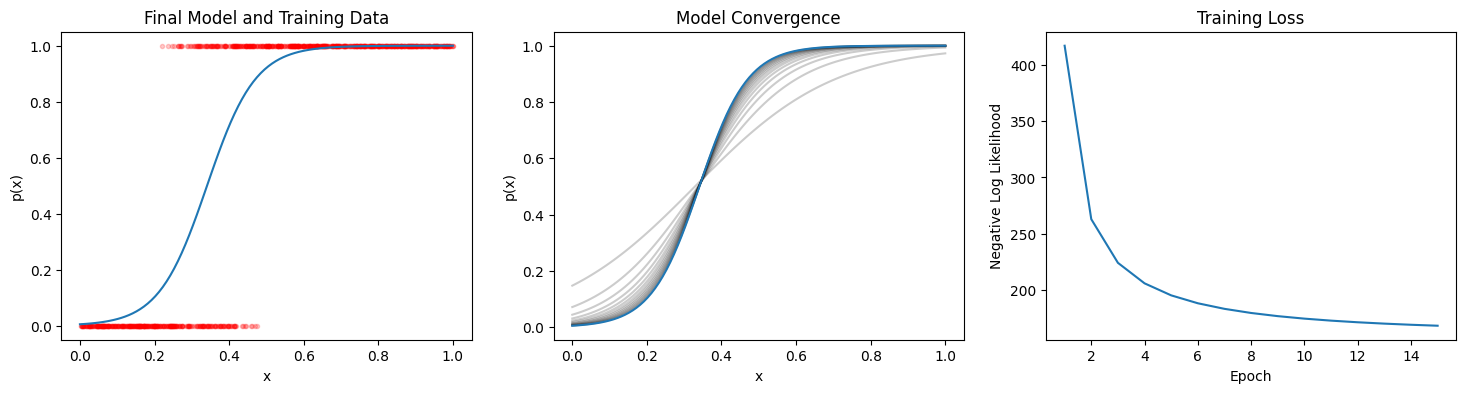

In [3]:
from re import L
input, label = generate_data()

# Make minibatches
inputs = torch.split(input, 32)
labels = torch.split(label, 32)

# Define the two variables to optimize
b1 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)
b2 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)

# hyperparameters
alpha = 0.1  # learning rate
epochs = 15  # epochs to train

# plots
x_vals = np.linspace(0, 1, 100)
y_vals = []  # extra credit: track how the curve changes during training
losses = []  # extra credit: plot loss curve

# training loop
for epoch in range(epochs):

  # total loss for the current epoch
  total_loss = 0

  for x, y in zip(inputs,labels):

    # Calculate p_x as per formula above
    p_x = torch.sigmoid(b1 + b2 * x)

    # Calculate the negative log likelihood loss for the current minibatch
    loss = -torch.sum(y * torch.log(p_x) + (1 - y) * torch.log(1 - p_x))

    # add loss on current minibatch to total loss
    total_loss += loss.item()

    # Calculate the gradient of the loss w.r.t. the inputs
    # (note: gradients are w.r.t. the parameters, not the inputs)

    # manually calculate gradients instead of calling loss.backward()
    # dL/db1 = p(x) - y
    # dL/db2 = (p(x) - y) * x

    error = p_x - y  # common error factor
    dldb1 = error.sum()  # gradient w.r.t b1
    dldb2 = (error * x).sum()  # gradient w.r.t b2

    # Update the parameters b according to SGD formula

    # allows us to update b1 and b2 in-place without
    # causing autograd to throw an error
    with torch.no_grad():
      b1 -= alpha * dldb1
      b2 -= alpha * dldb2

  # Print out the loss value for the current epoch
  print(f"Epoch [{(epoch + 1):02}/{epochs}], Loss: {total_loss:.2f}")

  # extra credit: store current loss
  losses.append(total_loss)

  # extra credit: store current learned function
  y_vals.append(1 / (1 + np.exp(-(b1.item() + b2.item() * x_vals))))

print()

# Reproduce the image above to validate your result.

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,4))

# plot the training data
for record in zip(input, label):
  ax1.plot(record[0], record[1], 'r.', alpha=0.2)

# plot the final learned function
ax1.plot(x_vals, y_vals[-1])

ax1.set_title("Final Model and Training Data")
ax1.set_xlabel("x")
ax1.set_ylabel("p(x)")

# plot the functions learned after each epoch
for curve in y_vals[:-1]:
  ax2.plot(x_vals, curve, 'k', alpha=0.2)

ax2.plot(x_vals, y_vals[-1])

ax2.set_title("Model Convergence")
ax2.set_xlabel("x")
ax2.set_ylabel("p(x)")

# plot the loss curve

ax3.plot(range(1, epochs + 1), losses)
ax3.set_title("Training Loss")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Negative Log Likelihood")

plt.show()

print()

# Part 2-1

Researchers have measured a bivariate timeseries, but the equipment was unreliable so the data has gaps as well as noise. The data can be found in [data.csv](https://gist.github.com/tmramalho/51733432c88e2b834dbd70353849f887)

In this exercise, we want to train an [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) to regress the full observed trajectory from the measured data. Formally, the MLP will be used to approximate the function $f:\mathbb{R} \rightarrow \mathbb{R}^2 ; f(t) = (x(t), y(t))$. In other words, the model takes the current time as an input, and predicts the values of `x` and `y` at that time based only on the measured data.

Your task is to define the data loader, the MLP model and the loss function to complete this task successfully. For this problem you will need to use a regression loss, not a classification loss.

Successful training should result in a data interpolation similar to the below:
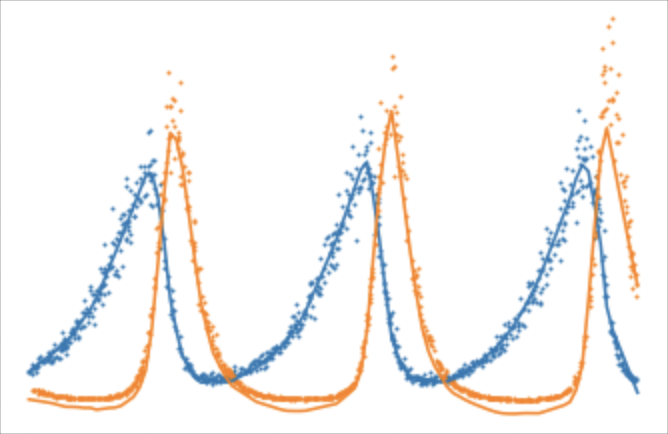

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

In [5]:
class Net(nn.Module):
    '''Model to regress 2d time series values given scalar input.'''
    def __init__(self, xy_mean, xy_std):
        super(Net, self).__init__()
        self.xy_mean = torch.tensor(xy_mean.values, dtype=torch.float32)
        self.xy_std = torch.tensor(xy_std.values, dtype=torch.float32)

        # MLP
        self.net = nn.Sequential(
          nn.Linear(1, 128),
          nn.ReLU(inplace=True),
          nn.Linear(128, 128),
          nn.ReLU(inplace=True),
          nn.Linear(128, 128),
          nn.ReLU(inplace=True),
          nn.Linear(128, 2),
        )

    def forward(self, x):

      # predict in normalized space
      xy_norm = self.net(x)

      # transform back to original space
      return xy_norm * self.xy_std + self.xy_mean

In [6]:
class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file):

      # read and preprocess the data
      df = pd.read_csv('data.csv')
      df.replace({'-':np.nan}, inplace=True)
      df.x = df.x.astype(float)
      df.y = df.y.astype(float)
      df.dropna(inplace=True)
      df.reset_index(inplace=True, drop=True)

      # normalize inputs
      self.t_mean = df['t'].mean()
      self.t_std = df['t'].std()
      df['t'] = (df['t'] - self.t_mean) / self.t_std

      # normalize outputs
      self.xy_mean = df[['x','y']].mean()
      self.xy_std  = df[['x','y']].std()
      df[['x','y']] = (df[['x','y']] - self.xy_mean) / self.xy_std

      self.t = torch.from_numpy(df['t'].values).float().unsqueeze(1)  # reshape
      self.xy = torch.from_numpy(df[['x','y']].values).float()

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        return self.t[idx], self.xy[idx]

In [7]:
BATCH_SIZE = 32

dataset = TimeSeriesDataset('data.csv')
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

def loss_fn(outputs, labels):

  # use mean squared error for regression
  return ((outputs - labels) ** 2).mean()

net = Net(dataset.xy_mean, dataset.xy_std)
optimizer = optim.Adam(net.parameters(), lr=1e-3)  # use Adam optimizer

In [8]:
training_losses = []

epochs = 300

for epoch in range(epochs):

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
      inputs, labels = data

      # reverse the output scaling
      labels_reversed = labels * net.xy_std + net.xy_mean

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = loss_fn(outputs, labels_reversed)
      loss.backward()
      optimizer.step()

      # accumulate loss
      running_loss += loss.item()

      # print statistics
      # colab won't print this anyway
      '''
      if i % 20 == 19:    # print every 20 mini-batches
          print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 20))
          running_loss = 0.0
      '''

  # print every 30 epochs
  if epoch % 30 == 29:
    print(f"Epoch [{(epoch + 1):03}/{epochs}], Loss: {running_loss:.3f}")

  training_losses.append(running_loss)

print('Finished Training')

Epoch [030/300], Loss: 9.939
Epoch [060/300], Loss: 4.287
Epoch [090/300], Loss: 3.507
Epoch [120/300], Loss: 2.537
Epoch [150/300], Loss: 2.008
Epoch [180/300], Loss: 1.745
Epoch [210/300], Loss: 2.054
Epoch [240/300], Loss: 2.046
Epoch [270/300], Loss: 1.803
Epoch [300/300], Loss: 1.444
Finished Training


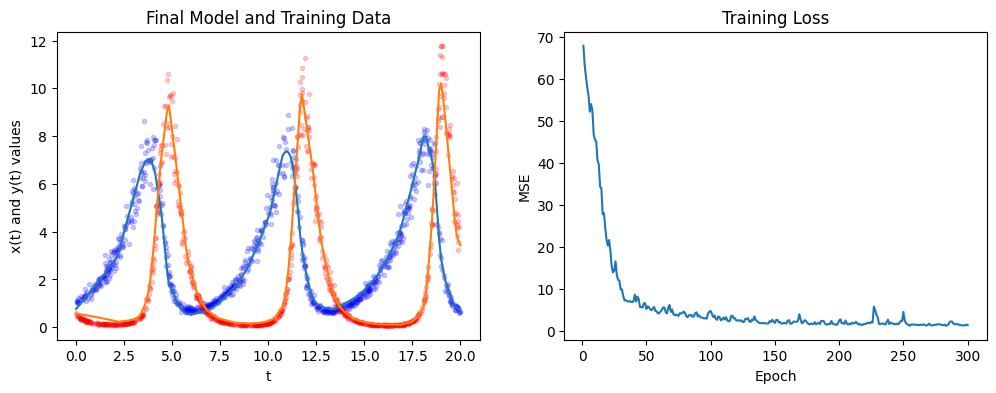

In [9]:
# Plot results to validate training

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# data
df = pd.read_csv('data.csv')
df.replace({'-':np.nan}, inplace=True)
df.x = df.x.astype(float)
df.y = df.y.astype(float)
df.reset_index(inplace=True, drop=True)

ax1.plot(df.t, df.x, 'b.', alpha=0.2)
ax1.plot(df.t, df.y, 'r.', alpha=0.2)

# learned curves
t = np.linspace(0, 20, 200).astype(np.float32)
t_norm = (t - dataset.t_mean) / dataset.t_std
inputs = torch.from_numpy(t_norm).unsqueeze(1).float()
outputs = net(inputs).detach().cpu().numpy()

ax1.plot(t, outputs[:,0])
ax1.plot(t, outputs[:,1])

ax1.set_title('Final Model and Training Data')
ax1.set_xlabel('t')
ax1.set_ylabel('x(t) and y(t) values')

# training loss
ax2.plot(range(1,301), training_losses)
ax2.set_title('Training Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MSE')

print()

# Part 2-2 Time-series extension

The simplified model above will only work well if $t\in[0,20]$.
Create a different model that can extrapolate `x,y` predictions to $t>20$.
Assume that the model has access to the same data as above, and is tasked to predict up to $t=100$. You can change anything in the above setup as needed, including model architecture, loss function, training procedure or data loader.

There are several different correct approaches to tackle this problem, all with different pros and cons, so make sure to explain your reasoning for the different choices made.


# Extension: add engineered features (sinusoidal and polynomial functions of t)

The data clearly has periodic behavior. This extension adds simple engineered features using sinusoidal and polynomial functions.

The sinusoidal features allow the neural network to easily learn the periodic behavior from the constrained window of [0, 20] that will extrapolate to [0, 100] (or any arbitrarily larger window).

The polynomial features allow the neural network to learn any drift or trend underneath the periodic oscillation.

This way, we can train a relatively small neural network to learn the function over the available window.

In [10]:
class Net(nn.Module):
    """MLP on engineered features."""
    def __init__(self, xy_mean, xy_std, in_dim):
        super().__init__()
        self.xy_mean = torch.tensor(xy_mean.values, dtype=torch.float32)
        self.xy_std  = torch.tensor(xy_std.values,  dtype=torch.float32)

        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),  # note: expanded input feature space
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128,  2),
        )

    def forward(self, x):
        xy_norm = self.net(x)
        return xy_norm * self.xy_std + self.xy_mean

In [11]:
import math

class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file):

        df = pd.read_csv(csv_file)
        df.replace({'-':pd.NA}, inplace=True)
        df.dropna(inplace=True)
        df[['x','y']] = df[['x','y']].astype(float)
        df.reset_index(drop=True, inplace=True)

        # normalize t
        self.t_mean, self.t_std = df['t'].mean(), df['t'].std()
        df['t'] = (df['t'] - self.t_mean) / self.t_std
        t = torch.from_numpy(df['t'].values).float().unsqueeze(1)

        # normalize outputs
        self.xy_mean = df[['x','y']].mean()
        self.xy_std  = df[['x','y']].std()
        df[['x','y']] = (df[['x','y']] - self.xy_mean) / self.xy_std
        self.xy = torch.from_numpy(df[['x','y']].values).float()

        # build polynomial + sinusoidal features

        #  polynomial features: [1, t, t^2]
        poly = torch.cat([torch.ones_like(t), t, t**2], dim=1)

        # sinusoidal features: sin(2*pi*t/p), cos(2*pi*t/p)
        # loosely estimate period = 7 from the chart/data table
        # in reality want to estimate using, for example, autocorrelation
        self.period = 7
        sinusoidal_terms = [torch.sin(2 * math.pi * t / self.period),
                         torch.cos(2 * math.pi * t / self.period)]

        sinusoidal = torch.cat(sinusoidal_terms, dim=1)

        # final matrix with polynomial and sinusoidal features
        self.features = torch.cat([poly, sinusoidal], dim=1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.xy[idx]

In [12]:
BATCH_SIZE = 32
dataset = TimeSeriesDataset('data.csv')
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

net = Net(dataset.xy_mean, dataset.xy_std, in_dim=dataset.features.shape[1])
optimizer = optim.Adam(net.parameters(), lr=1e-3)

def loss_fn(pred, target):
    return ((pred - target)**2).mean()

In [13]:
training_losses = []

epochs = 300

for epoch in range(epochs):

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
      inputs, labels = data

      # reverse the output scaling
      labels_reversed = labels * net.xy_std + net.xy_mean

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = loss_fn(outputs, labels_reversed)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()

  # print every 30 epochs
  if epoch % 30 == 29:
    print(f"Epoch [{(epoch + 1):03}/{epochs}], Loss: {running_loss:.3f}")

  training_losses.append(running_loss)

print('Finished Training')

Epoch [030/300], Loss: 3.562
Epoch [060/300], Loss: 1.767
Epoch [090/300], Loss: 2.229
Epoch [120/300], Loss: 1.463
Epoch [150/300], Loss: 1.428
Epoch [180/300], Loss: 1.563
Epoch [210/300], Loss: 1.564
Epoch [240/300], Loss: 1.352
Epoch [270/300], Loss: 1.308
Epoch [300/300], Loss: 1.192
Finished Training


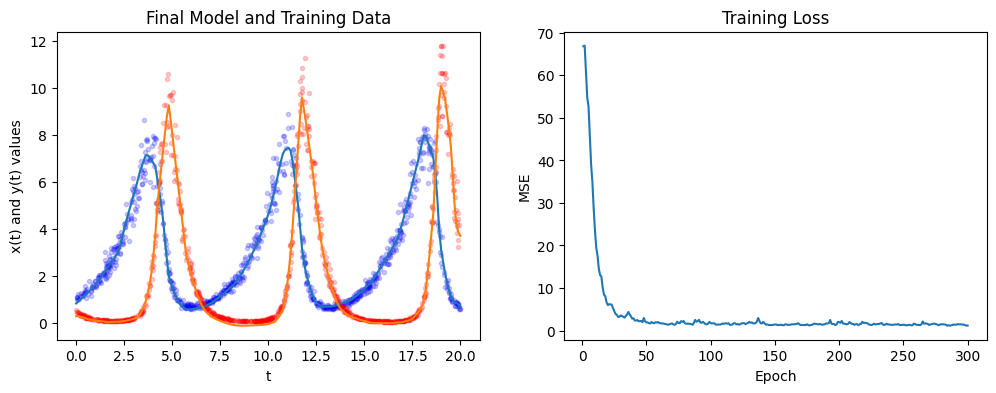

In [14]:
# Plot results to validate training

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# data
df = pd.read_csv('data.csv')
df.replace({'-':np.nan}, inplace=True)
df.x = df.x.astype(float)
df.y = df.y.astype(float)
df.reset_index(inplace=True, drop=True)

ax1.plot(df.t, df.x, 'b.', alpha=0.2)
ax1.plot(df.t, df.y, 'r.', alpha=0.2)

# learned curves
t = np.linspace(0, 20, 200).astype(np.float32)
t_norm = (t - dataset.t_mean) / dataset.t_std

tn = torch.from_numpy(t_norm).unsqueeze(1).float()

t_norm_tensor = torch.from_numpy(t_norm).unsqueeze(1).float()  # for poly
t_orig_tensor = torch.from_numpy(t).unsqueeze(1).float()  # for sin/cos

poly = torch.cat([torch.ones_like(t_norm_tensor),
                  t_norm_tensor,
                  t_norm_tensor**2
                  ], dim=1)

fourier = torch.cat([torch.sin(2*math.pi * tn / dataset.period),
                     torch.cos(2*math.pi * tn / dataset.period)
                     ], dim=1)

feats = torch.cat([poly, fourier], dim=1)

# 5) forward & plot
with torch.no_grad():
    out = net(feats)
preds = out.cpu().numpy()

ax1.plot(t, preds[:,0])
ax1.plot(t, preds[:,1])

ax1.set_title('Final Model and Training Data')
ax1.set_xlabel('t')
ax1.set_ylabel('x(t) and y(t) values')

# training loss
ax2.plot(range(1,301), training_losses)
ax2.set_title('Training Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MSE')


print()

# Part 3-1a

Please implement the below function `min_dist`. This function should take a sparse list of 2D coordinates, and map them to a 2D tensor of a specified resolution. The values of each pixel in the tensor should correspond to the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between that pixel and the closest pixel which contains a data point.

You can use either numpy or pytorch tensor operations to implement the function. Use only tensor operations, no for-loops are necessary.

Here are the example outputs for the two test cases highlighted below:

Case 1: data at `[0.4, 0.3], [0.6, 0.7]`, resolution 20 pixels.

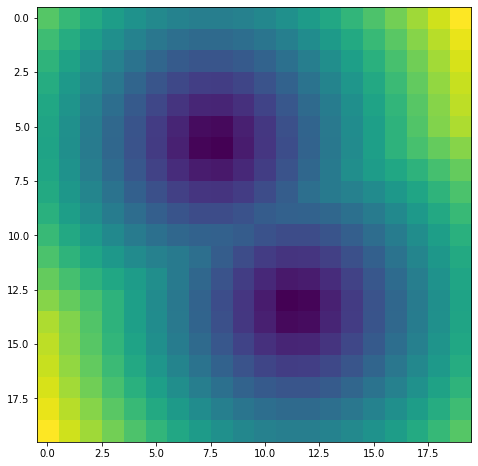


Case 2: data at `[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]`, resolution 256 pixels.

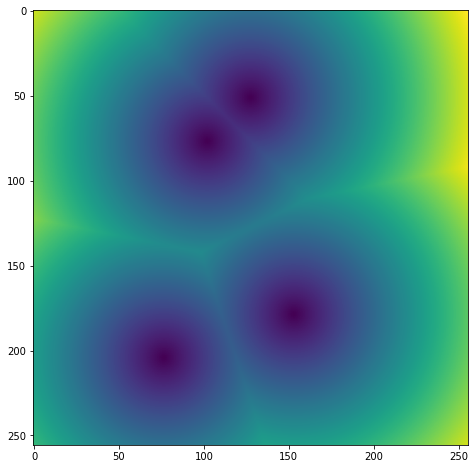


In [15]:
def min_dist(points, res):
  """Calculates a 2D tensor with the minimum distance from each pixel to data.

  Inputs:
    * points: a python list of 2D coordinates, normalized in the range [0,1]
    * res: the resolution of the output tensor.
  Returns:
    A res x res square tensor with floating point values corresponding to the
    euclidean distance to the closest point in points.
  """

  # de-normalize i.e. map normalized points on [0,1] to pixel coords [0..res-1]
  pts = torch.tensor(points, dtype=torch.float32) * (res - 1)

  # build 1-D tensor [0, 1, 2, ..., res - 1]
  vals = torch.arange(res, dtype=torch.float32)

  # build a res × res grid of pixel coordinates

  # yy[i,j]=i for all columns j
  # xx[i,j]=j for all rows i
  #
  # e.g.
  # yy = [[0,0,0],
  #       [1,1,1],
  #       [2,2,2]]
  #
  # xx = [[0,1,2],
  #       [0,1,2],
  #       [0,1,2]]

  yy, xx = torch.meshgrid(vals, vals, indexing='ij')  # both are (res, res)

  # will use coords to do the distance calculation as a vectorized operation
  coords = torch.stack((xx, yy), dim=-1)  # (res, res, 2)

  # insert dummy axis at index 2 of coords to align dimensions, then
  # broadcast over the point‐dimension to calculate vector distance
  # of every pixel to every point
  diff = coords.unsqueeze(2) - pts.view(1, 1, -1, 2)  # (res, res, n, 2)

  # compute squared distance on the last dimension (the differences)
  dist2 = diff.pow(2).sum(dim=-1)  # (res, res, n)

  # take the min over the points-dimension
  min2, index = dist2.min(dim=2)  # (res, res)

  # square root to get Euclidean distance
  return torch.sqrt(min2)


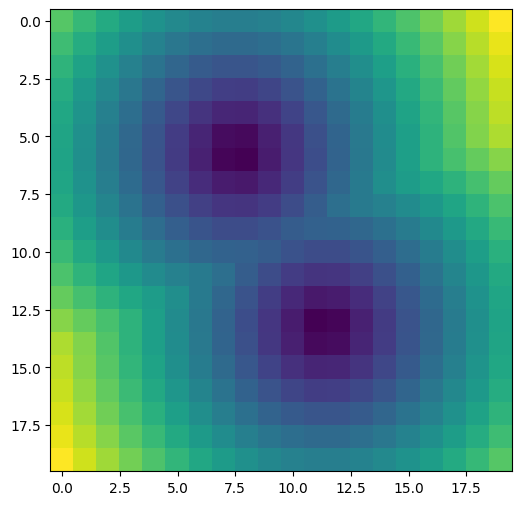

In [16]:
# Case 1:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7]], 20)
plt.figure(figsize=(6, 6))
plt.imshow(distance_to_data)

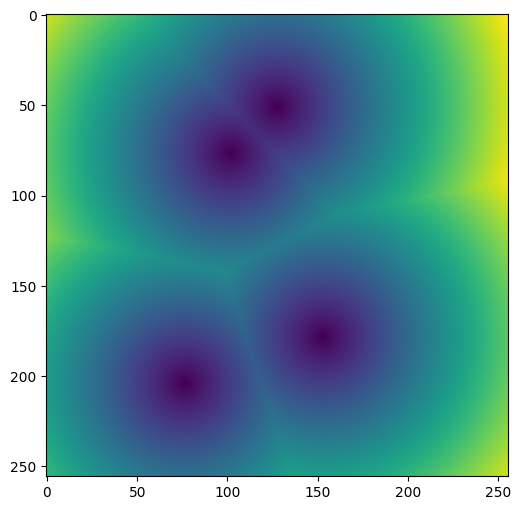

In [17]:
# Case 2:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]], 256)
plt.figure(figsize=(6, 6))
plt.imshow(distance_to_data)

# Part 3-1b: Batched version

As a next step, improve the `min_dist` function to support batches.
The `points` array is now expected to be a tensor with shape [batch_size, num_points, 3], generated by `create_points`.
`min_dist` should return a batch of maps with shape [batch_size, res, res].
Again, make sure to implement `min_dist` using **no for-loops**.
Demonstrate your function output with `batch_size=3` and `num_points=4`.

In [18]:
def create_points(batch_size, num_points):
  coords = np.random.rand(batch_size, num_points, 2)
  return coords

In [19]:
def min_dist(points, res):
  """Calculates a 3D tensor with the minimum distance from each pixel to data.

  Inputs:
    * points: a numpy array of 2D coordinates and point values, normalized to
              be in the range [0,1]. The expected shape is [B, P, 2].
    * res: the resolution of the output tensor.
  Returns:
    A res x res square tensor with floating point values corresponding to the
    euclidean distance to the closest point in points. The return tensor
    shape is [B, res, res].
  """
  # map to [0..res-1]
  pts = torch.tensor(points, dtype=torch.float32) * (res - 1)  # (B, P, 2)
  B, P, _ = pts.shape

  # create grid of pixel coords
  vals = torch.arange(res, dtype=torch.float32)
  yy, xx = torch.meshgrid(vals, vals, indexing="ij")
  coords = torch.stack((xx, yy), dim=-1)

  # Reshape coords to match the number of points P
  coords = coords.unsqueeze(0).expand(B, res, res, 2)

  # broadcast so coords is (B, res, res, P, 2)
  # and insert axes so pts is (B, 1, 1, P, 2)
  pts_exp = pts.unsqueeze(1).unsqueeze(1)

  # squared distances (B, res, res, P)
  dist2 = (coords.unsqueeze(3) - pts_exp).pow(2).sum(dim=-1)

  # keep the minimum over the points dimension (B, res, res)
  min2, index = dist2.min(dim=-1)

  return torch.sqrt(min2)

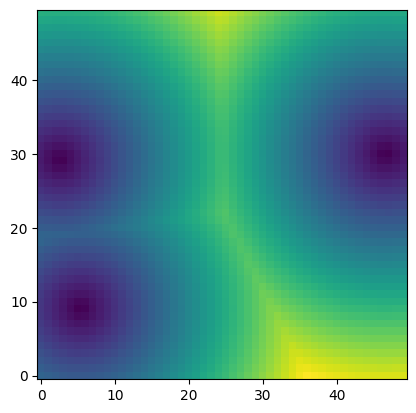

In [20]:
# demo
batch_size = 3
num_points = 3
res = 50
points = create_points(batch_size, num_points)
maps = min_dist(points, res)

np.random.seed(42)
plt.figure()
plt.imshow(maps[2], origin='lower')

# Part 3-2: Scalable version

Assume `res` can be very large (up to 65,536). Running the above function will likely cause the computer's RAM to be filled up, and fail (on a free colab instance, even 16,384 `res` will crash with `batch_size=3` and `num_points=4`).
Extend the above version of `min_dist` to calculate the result tensor at such high resolution without running out of RAM. This function may be less computationally efficient, as long as it can successfully run.

In [21]:
def min_dist_chunked(points, res):
  """
  Memory-efficient, chunked computation of the batch distance maps.
  Inputs:
    * points: np array, shape (B, P, 2), coords in [0,1]
    * res:     int, resolution per axis
    * chunk_size: max block size along each axis
  Returns:
    * dists:   np array, shape (B, res, res)
  """
  # break up the grid into chunks that will fit into memory
  chunk_size = 1024
  B, P, _ = points.shape

  # scale points to pixel coordinates
  pts = torch.tensor(points, dtype=torch.float32) * (res - 1)
  # preallocate result tensor
  result = torch.empty((B, res, res), dtype=torch.float32)
  full_x = torch.arange(res, dtype=torch.float32)

  # iterate over y- and x-chunks
  for y0 in range(0, res, chunk_size):
    y1 = min(res, y0 + chunk_size)
    ys = torch.arange(y0, y1, dtype=torch.float32)
    for x0 in range(0, res, chunk_size):
        x1 = min(res, x0 + chunk_size)
        xs = full_x[x0:x1]

        # build grid for this block (h, w, 2)
        yy, xx = torch.meshgrid(ys, xs, indexing='ij')
        block_coords = torch.stack((xx, yy), dim=-1)

        # compute squared distances: (B, h, w, P, 2) -> (B, h, w, P)
        diff = block_coords.unsqueeze(0).unsqueeze(3) - pts.unsqueeze(1).unsqueeze(1)
        dist2 = diff.pow(2).sum(-1)

        # take min over points and sqrt
        min2, index = dist2.min(dim=-1)
        result[:, y0:y1, x0:x1] = min2.sqrt()

  return result

In [22]:
# demo
np.random.seed(0)
batch_size = 3
num_points = 4
res = 16384
points = create_points(batch_size, num_points)
maps = min_dist_chunked(points, res)